In [1]:
import numpy as np
import pandas as pd
from knn import MatrixBasedKNN, KDTreeBasedKNN
from cross_validation import accuracy, cross_validation
from window import Window
from noise import margin, margin_new
from scipy.spatial.distance import cosine, euclidean, minkowski
from sklearn.neighbors import KDTree, DistanceMetric
import matplotlib.pyplot as plt
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
# input data
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
X_train, Y_train = df[df.columns[1:]].values, df['label'].values
X_test = df_test.values

In [3]:
# utility functions
def plot_image(img, im_size=28):
    pylab.imshow(img.reshape(im_size, im_size), cmap=pylab.cm.gray)
    
def plot_grid(imgs, nrows, ncols, dataset=X_train, im_size=28):
    fig = pyplot.gcf()
    fig.set_size_inches(ncols*2,nrows*2)
    for pylab_index, img in enumerate(imgs):
        pylab.subplot(nrows, ncols, pylab_index + 1)
        plot_image(img)
        pylab.axis('off')
def output_to_csv(result_list, filename):
    df = pd.DataFrame({'Id':range(len(result_list)),'label':result_list})
    df['label'] = df['label'].apply(int)
    df.to_csv(filename, column=['Id','label'],index=False)

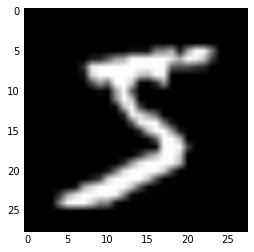

In [4]:
#example image
plot_image(X_train[0])

## Average class members

Посмотрим как выглядит средняя цифра в train.csv. Для этого просто усредним значения векторов в каждом классе.


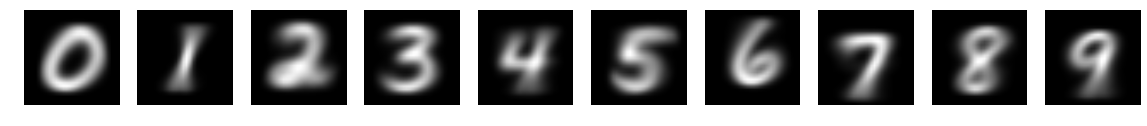

In [5]:
#average images
average_class_imgs = []
for c1ass in xrange(10):
    class_imgs = df.loc[df['label'] == c1ass]
    avg_img = np.average(class_imgs[class_imgs.columns[1:]].values,0)
    average_class_imgs.append(avg_img)
#output of average images
plot_grid(average_class_imgs, nrows=1, ncols=10)

## Matrix Based KNN

Сначала самый медленный вариант с перемножением матриц в 2 цикла.

In [6]:
# KNN using two loops
knn_2loops = MatrixBasedKNN(num_loops=2)
knn_2loops = knn_2loops.fit(X_train, Y_train, 'l2')
%time y_pred2 = knn_2loops.predict(X_train[:100])

CPU times: user 38.8 s, sys: 0 ns, total: 38.8 s
Wall time: 38.8 s


Проверим что все работает на части X_train:

In [7]:
#verification
print "it works!" if np.linalg.norm(y_pred2 - Y_train[:100]) < 1e-4 else "doesn't work :("

it works!


Теперь избавимся от одного цикла. 

Оставим только цикл по тестовым объектам, а l2 - норму посчитаем, используя numpy.

In [8]:
# KNN using one loop

knn_1loop = MatrixBasedKNN(num_loops=1)
knn_1loop = knn_1loop.fit(X_train, Y_train, 'l2')
%time y_pred1 = knn_1loop.predict(X_train[:100])

CPU times: user 4.7 s, sys: 1.47 s, total: 6.16 s
Wall time: 6.16 s


Проверим, что все работает:

In [9]:
#verification
print('good' if np.linalg.norm(y_pred1 - y_pred2) < 1e-4 else 'fail')

good


Теперь попытаемся использовать только перемножения матриц в numpy.

Пусть $T$ -- матрица, строки которой тестовые векторы, $P$ -- матрица, строки которой обучающие векторы, а $D$ -- искомая матрица расстояний.
Тогда $d_{ij}^2 = \sum_k{|p_{jk} - t_{ik}|^2} = \sum_k{p_{jk}^2} + \sum_k{t_{ik}^2} -2\sum_k{t_{ik}p_{jk}}$
Заметим, что элементы $\sum_k{p_{jk}^2}$ это диагональные элементы матрицы $P \cdot P^{T}$, элементы  $\sum_k{t_{jk}^2}$ это диагональные элементы матрицы $T \cdot T^{T}$, а $\sum_k{t_{ik}p_{jk}}$ -- элементы $T\cdot P^{T}$. Но перемножать матрицы $P \cdot P^{T}$ и $T \cdot T^{T}$ незачем, если мы хотим получить только диагональные элементы. Поэтому просто как и в случае с knn_1loop посчитаем l2-нормы строчек с помощью numpy, а матрицы $T\cdot P^{T}$ придется перемножить. 
Потом, чтобы получить матрицу $D$ нужно к $(-2) \cdot T\cdot P^{T}$ прибавить построчно диагональ $T \cdot T^{T}$, а потом по столбцам прибавить диагональ $P \cdot P^{T}$.


In [11]:
# KNN without loops
knn_no_loop = MatrixBasedKNN(num_loops=0)
knn_no_loop = knn_no_loop.fit(X_train, Y_train, 'l2')
%time y_pred = knn_no_loop.predict(X_train[:100], k=1)

CPU times: user 3.69 s, sys: 24 ms, total: 3.71 s
Wall time: 3.71 s


Проверим, что все работает.

In [12]:
#verification
print 'good' if np.linalg.norm(y_pred - y_pred2) < 1e-4 else 'fail'

good


## KD_tree based KNN

Теперь будем использовать KDTree.

In [13]:
# KNN using kd_tree
knn_kd_tree = KDTreeBasedKNN()
knn_kd_tree = knn_kd_tree.fit(X_train, Y_train)
%time y_pred = knn_kd_tree.predict(X_train[:1000],k=1)

CPU times: user 7.29 s, sys: 0 ns, total: 7.29 s
Wall time: 7.28 s


In [14]:
#verification
print "it works!" if np.linalg.norm(y_pred - Y_train[:1000]) < 1e-4 else "doesn't work :("

it works!


## Accuracy score and Cross Validation Algorithm

Будем использовать алгоритм кросс-валидации для подбора параметров алгоритма.

Сначала проверим, что верно считается accuracy score.

In [15]:
print 'good' if accuracy([1, 1, 1, 0], [1, 1, 1, 5]) == 0.75 else 'fail'

good


Теперь запустим алгоритм кросс-валидации для различных метрик.

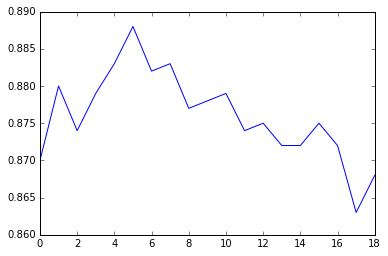

In [23]:
#l2 norm
scores_l2 = []
for i in range(1,20):
    scores_l2.append(cross_validation(X_train[:1000],Y_train[:1000],'l2',i))
plt.plot(scores_l2)

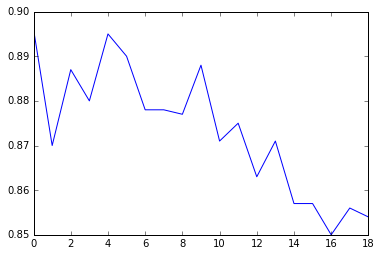

In [44]:
#cosine distance
scores_cosine = []
for i in range(1,20):
    scores_cosine.append(cross_validation(X_train[:1000],Y_train[:1000],'cosine',i))
plt.plot(scores_cosine)

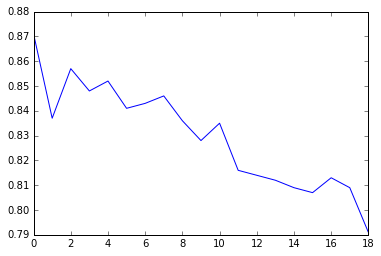

In [46]:
#l1 distance
scores_l1 = []
for i in range(1,20):
    scores_l1.append(cross_validation(X_train[:1000],Y_train[:1000],'l1',i))
plt.plot(scores_l1)

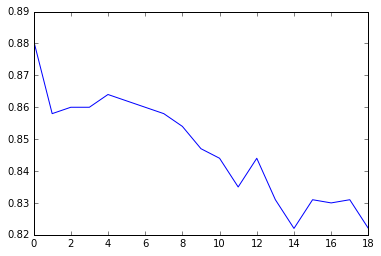

In [48]:
#l3 distance
scores_l3 = []
for i in range(1,20):
    scores_l3.append(cross_validation(X_train[:1000],Y_train[:1000],'l3',i))
plt.plot(scores_l3)

Как можно видеть, accuracy score падает при увеличении числа соседей.

Также по данным этой кросс-валидации лучший accuracy score у l2-нормы при k = 5, хотя на kaggle косинусная метрика с k = 1 дает лучший результат, чем l2.
Возможно это из-за того, что подбор параметров проводится только на части выборки, причем возможно хорошо написанные и плохо написанные цифры не равномерно распределены в обучающей выборке, а мы тут берем первые 1000 картинок.


## Удаление шума

Попытаемся удалить из обучающей выборки шумовые объекты

### Первый способ:
Сначала будем рассчитывать margin как neighbours_in_class - most_frequent_class_neighbours.
neighbours_in_class это количество соседей из k ближайших, которые принадлежат тому же классу что и рассматриваемый объект, а most_frequent_class_neighbours -- это количество соседей среди k ближайших, которые находятся в самом многочисленном классе не считая класс самого объекта.

In [20]:
#print Y_train
margins_list = margin(xrange(X_train.shape[0]),10,X_train,Y_train)
margins1 = {}
for i in xrange(len(margins_list)):
    margins1[i] = margins_list[i]

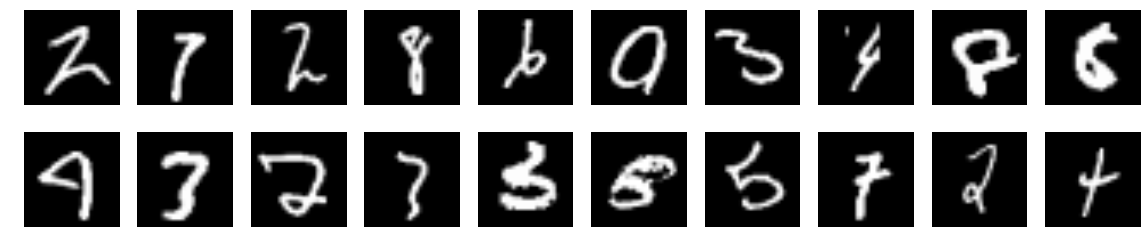

In [27]:
imgs = sorted(margins1.items(),key = lambda x : x[1])[:20]
#print noise images
plot_grid(X_train[map(lambda x:x[0],imgs)],nrows = 2,ncols = 10)

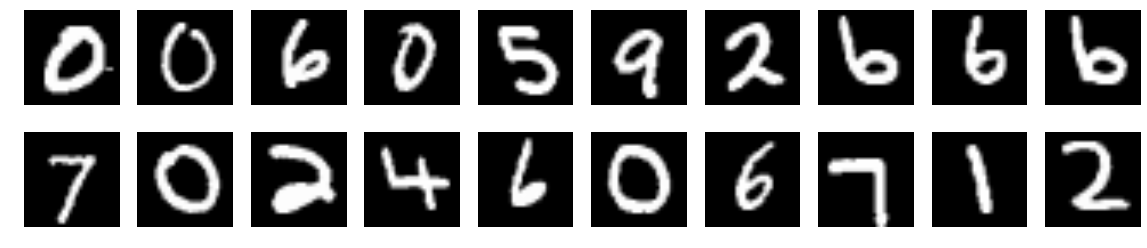

In [26]:
imgs = sorted(margins1.items(),key = lambda x : x[1])[-20:]
#print prototypes
plot_grid(X_train[map(lambda x:x[0],imgs)],nrows = 2,ncols = 10)

#### Распределение marginов объектов

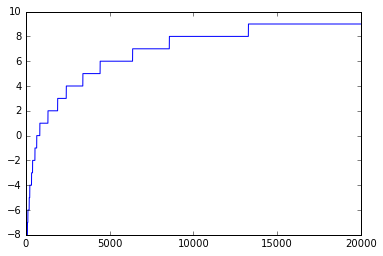

In [29]:
plot(np.array(sorted(margins_list)))
plt.show()

### Второй способ: 
margin = dist_to_class - dist_to_most_frequent_class -- определяется аналогично первому случаю

In [18]:
margins_list1 = margin_new(xrange(X_train.shape[0]),10,X_train,Y_train)
margins1 = {}
for i in xrange(len(margins_list1)):
    margins1[i] = margins_list1[i]

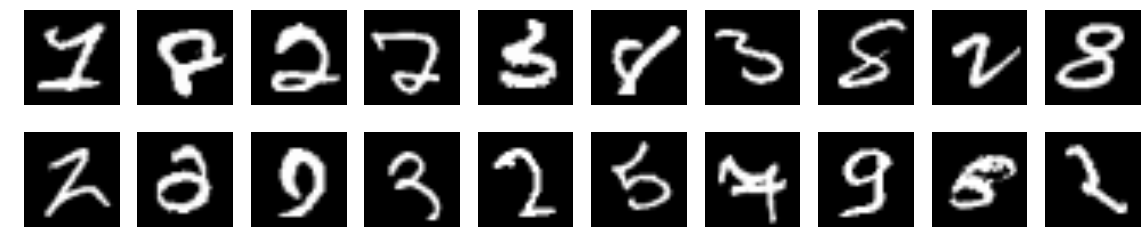

In [21]:
imgs = sorted(margins1.items(),key = lambda x : x[1])[:20]
#print noise images
plot_grid(X_train[map(lambda x:x[0],imgs)],nrows = 2,ncols = 10)

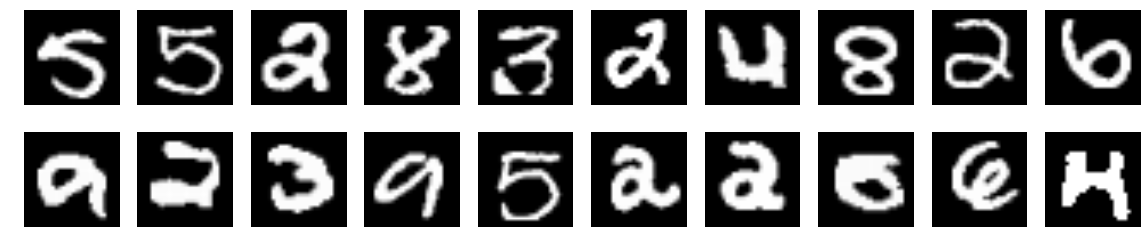

In [22]:
imgs = sorted(margins1.items(),key = lambda x : x[1])[-20:]
#print prototype images
plot_grid(X_train[map(lambda x:x[0],imgs)],nrows = 2,ncols = 10)

####  Распределение marginов объектов

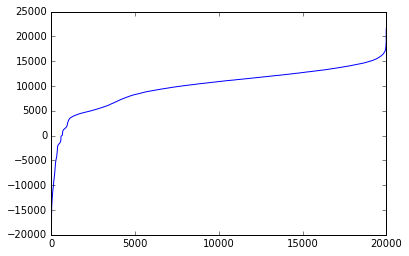

In [23]:
plot(np.array(sorted(margins_list1)))
plt.show()

Теперь удалим шумовые объекты из выборки (пользуясь результатами второго способа)

In [38]:
sorted_margins = sorted(margins1.items(),key = lambda x : x[1])
normal_indices = [item[0] for item in sorted_margins if item[1] > 5000]

## Тестирование алгоритма на выборке без шумовых объектов


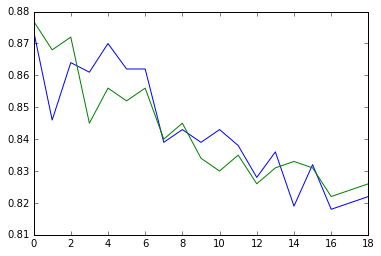

In [42]:
#l2 norm
scores_l2_noise = []
for i in range(1,20):
    scores_l2_noise.append(cross_validation(X_train[normal_indices[:1000]],Y_train[normal_indices[:1000]],'l2',i))
plt.plot(scores_l2)
plt.plot(scores_l2_noise)
plt.show()

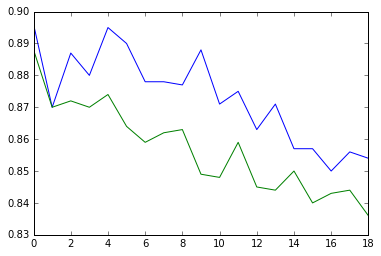

In [45]:
#cosine distance
scores_cosine_noise = []
for i in range(1,20):
    scores_cosine_noise.append(cross_validation(X_train[normal_indices[:1000]],Y_train[normal_indices[:1000]],'cosine',i))
plt.plot(scores_cosine)
plt.plot(scores_cosine_noise)
plt.show()

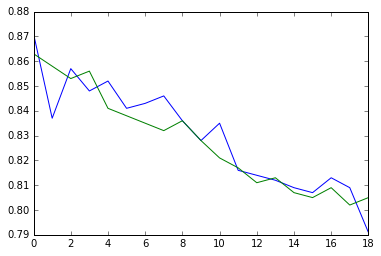

In [47]:
#l1 norm
scores_l1_noise = []
for i in range(1,20):
    scores_l1_noise.append(cross_validation(X_train[normal_indices[:1000]],Y_train[normal_indices[:1000]],'l1',i))
plt.plot(scores_l1)
plt.plot(scores_l1_noise)
plt.show()

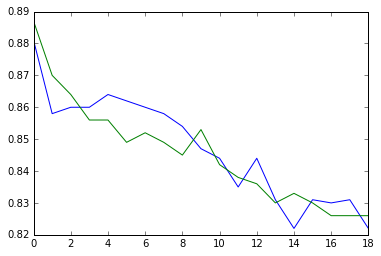

In [49]:
#l3 norm
scores_l3_noise = []
for i in range(1,20):
    scores_l3_noise.append(cross_validation(X_train[normal_indices[:1000]],Y_train[normal_indices[:1000]],'l3',i))
plt.plot(scores_l3)
plt.plot(scores_l3_noise)
plt.show()

На приведенных графиках зеленая линия -- для выборки без шума, а синяя с шумом.
Как видно, удаление шума не дает увеличения accuracy score при k > 1, за исключением пары случаев.

Наверное это происходит потому, что на метод 1NN очень сильно влияет шум: 
если ближе всех к объекту случайно оказался шумовой объект, то алгоритм выдаст неверный ответ. 
Bлияние шума уменьшается при росте k, поэтому зеленая ломаная почти всегда ниже синей.

## Метод парзеновского окна

Запустим кросс-валидацию для метода парзеновского окна переменной ширины. Будем перебирать ядра и метрики при k от 1 до 10.

(в cross_validation.py нужно закомментировать часть для knn и раскомментировать часть для window) 

In [5]:
kernels = ['optimal','gauss','triangular','rectangular','quartic']
metrics = ['l1','l2','l3','cosine']

Metric: l1


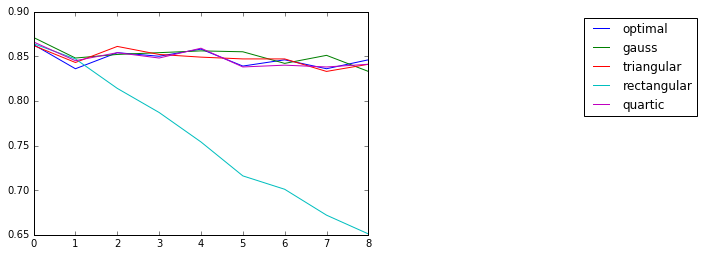

Metric: l2


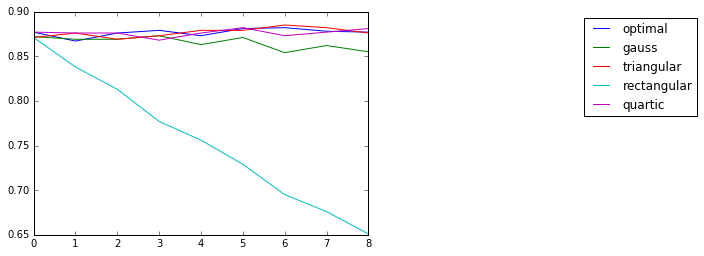

Metric: l3


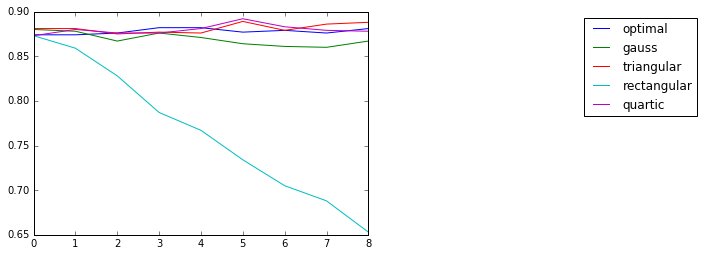

Metric: cosine


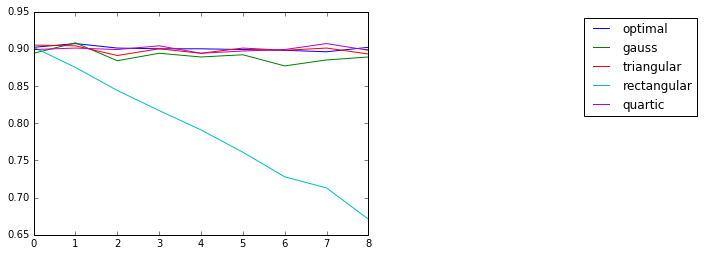

In [7]:
for metric in metrics:
    print 'Metric:', metric
    for kernel in kernels:
        scores_window = []
        for k in xrange(1,10):
            scores_window.append(cross_validation(X_train[:1000],Y_train[:1000],metric,k,kernel))
        plt.plot(scores_window,label=kernel)
    plt.legend(loc='upper right',bbox_to_anchor=(2, 1), ncol=1)
    plt.show()   

Итак получаем, что  лучший accuracy score у косинусной метрики при k = 5 и ядра optimal и при k = 7 и ядра quartic

Лучшие результаты на Kaggle получились у KNN c косинусной метрикой и k = 1 и у метода парзеновского окна с k = 5 и ядром optimal